# Preparating the project

In [10]:
# import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Sequential
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import gc
import warnings
import os, os.path

warnings.filterwarnings("ignore")

%matplotlib inline

In [11]:
# functions used in this project
def extract_values_from_history(history):
    train_accuracy = history.history["accuracy"]
    validation_accuracy = history.history["val_accuracy"]

    train_loss = history.history["loss"]
    validation_loss = history.history["val_loss"]

    return train_accuracy, validation_accuracy, train_loss, validation_loss


def accuracy_and_loss_graph(
    train_accuracy, validation_accuracy, train_loss, validation_loss
):
    # Accuracy and Loss graphical representation
    plt.figure(figsize=(8, 8))

    plt.subplot(2, 1, 1)
    plt.plot(train_accuracy, label="Training Accuracy")
    plt.plot(validation_accuracy, label="Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training and Validation Accuracy")

    plt.subplot(2, 1, 2)
    plt.plot(train_loss, label="Training Loss")
    plt.plot(validation_loss, label="Validation Loss")
    plt.ylabel("Cross Entropy")
    plt.title("Training and Validation Loss")
    plt.xlabel("epoch")
    plt.legend()
    plt.show()


def mean_metrics(history):
    mean_accuracy = round(np.mean(history.history["accuracy"]) * 100, 2)
    std_accuracy = round(np.std(history.history["accuracy"]) * 100, 2)
    mean_validation_accuracy = round(np.mean(history.history["val_accuracy"]) * 100, 2)
    std_validation_accuracy = round(np.std(history.history["val_accuracy"]) * 100, 2)

    mean_loss = round(np.mean(history.history["loss"]), 3)
    std_loss = round(np.std(history.history["loss"]), 3)
    mean_validation_loss = round(np.mean(history.history["val_loss"]), 3)
    std_validation_loss = round(np.std(history.history["val_loss"]), 3)

    print(
        f"Mean Accuracy: {mean_accuracy} +/- {std_accuracy} & Mean Validation Accuracy: {mean_validation_accuracy} +/- {std_validation_accuracy}"
    )
    print(
        f"Mean Loss: {mean_loss} +/- {std_loss} & Mean Validation Loss: {mean_validation_loss} +/- {std_validation_loss}"
    )


def make_model(model, learning_rate, droprate, size_inner):
    base_model = model(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

    base_model.trainable = False

    #####################################################

    inputs = keras.Input(shape=(224, 224, 3))
    base = base_model(inputs, training=False)

    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(size_inner, activation="relu")(vectors)

    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(20, activation="softmax")(drop)
    model = keras.Model(inputs, outputs)

    #####################################################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.sparse_categorical_crossentropy

    model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

    return model


def return_best_hps(tuner, train_set, callbacks):
    tuner.search(train_set, epochs=30, callbacks=[callbacks])
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    return best_hps


def print_hyperparameter(best_hps):
    print(
        f"""
      The hyperparameter search is complete.\n
      - Optimal learning rate: {best_hps.get('learning_rate')},\n
      - Optimal number of layers: {best_hps.get('size_inner')},\n
      - Optimal dropout: {best_hps.get("dropout")}.
      """
    )

In [12]:
# create constant used in all project
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
CHANNEL = 3
NUM_CLASSES = 20
stop_early = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=5)

# Exploratory Data Analysis

In [13]:
path = "data"

- Check the number of classes

In [ ]:
lst = os.listdir(path)
number_files = len(lst)
print(f"Number of classes: {number_files}")

Number of classes: 20


In [ ]:
dict_cat = {}

for _ in lst:
    _ = "data/" + _
    lst_pictures = os.listdir(_)
    number_pictures = len(lst_pictures)
    dict_cat[_] = number_pictures

In [ ]:
dict_cat = {k.replace("data/", ""): v for k, v in dict_cat.items()}

- Check the number of files for each classes

In [ ]:
# print a dictionary with breed name and number of picture for each
dict_cat

{'Sphynx': 350,
 'Egyptian Mau': 350,
 'Exotic Shorthair': 350,
 'Russian Blue': 350,
 'Bombay': 350,
 'Abyssinian': 350,
 'Maine Coon': 350,
 'Manx': 350,
 'Persian': 350,
 'Scottish Fold': 350,
 'Turkish Angora': 350,
 'American Shorthair': 350,
 'British Shorthair': 350,
 'American Bobtail': 350,
 'Siamese': 350,
 'Ragdoll': 350,
 'American Curl': 350,
 'Birman': 350,
 'Bengal': 350,
 'Norwegian Forest': 350}

In [ ]:
full_dataset = image_dataset_from_directory(
    path,
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
)

class_names = full_dataset.class_names

Found 7000 files belonging to 20 classes.


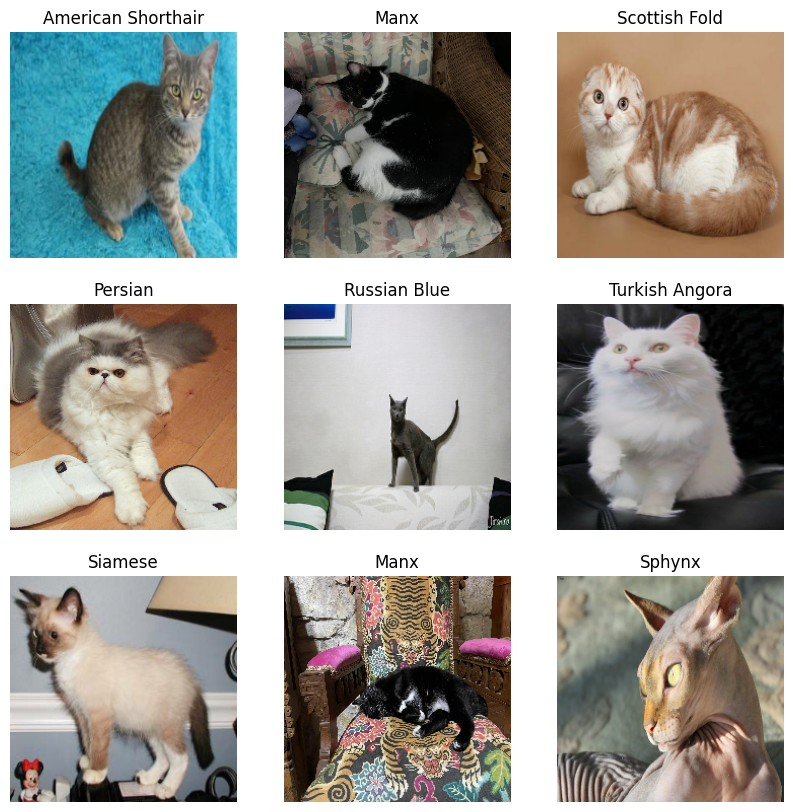

In [ ]:
# Displaying some pictures of train set
plt.figure(figsize=(10, 10))
for images, labels in full_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Modelisation

## Xception

### Training model

In [ ]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input

In [ ]:
img_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input, validation_split=0.2
)

train_set = img_gen.flow_from_directory(
    path,
    subset="training",
    seed=42,
    class_mode="sparse",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
)

val_set = img_gen.flow_from_directory(
    path,
    subset="validation",
    seed=42,
    class_mode="sparse",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
)

Found 5600 images belonging to 20 classes.
Found 1400 images belonging to 20 classes.


In [ ]:
print(train_set.class_indices)

{'Abyssinian': 0, 'American Bobtail': 1, 'American Curl': 2, 'American Shorthair': 3, 'Bengal': 4, 'Birman': 5, 'Bombay': 6, 'British Shorthair': 7, 'Egyptian Mau': 8, 'Exotic Shorthair': 9, 'Maine Coon': 10, 'Manx': 11, 'Norwegian Forest': 12, 'Persian': 13, 'Ragdoll': 14, 'Russian Blue': 15, 'Scottish Fold': 16, 'Siamese': 17, 'Sphynx': 18, 'Turkish Angora': 19}


In [ ]:
base_model = Xception(
    weights="imagenet", include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNEL)
)

base_model.trainable = False

inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNEL))

base = base_model(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax")(vectors)

model = keras.Model(inputs, outputs)

83683744/83683744 [==============================] - 3s 0us/step


In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=["accuracy"],
)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 20)                40980     
                                                                 
Total params: 20902460 (79.74 MB)
Trainable params: 40980 (160.08 KB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


In [ ]:
history = model.fit(train_set, epochs=10, validation_data=val_set)

Epoch 1/10
175/175 [==============================] - 41s 190ms/step - loss: 1.6875 - accuracy: 0.5482 - val_loss: 1.4366 - val_accuracy: 0.5914
Epoch 2/10
175/175 [==============================] - 30s 168ms/step - loss: 1.0006 - accuracy: 0.6968 - val_loss: 1.5968 - val_accuracy: 0.5950
Epoch 3/10
175/175 [==============================] - 30s 172ms/step - loss: 0.8218 - accuracy: 0.7339 - val_loss: 1.9110 - val_accuracy: 0.5886
Epoch 4/10
175/175 [==============================] - 31s 177ms/step - loss: 0.6948 - accuracy: 0.7852 - val_loss: 1.6845 - val_accuracy: 0.6050
Epoch 5/10
175/175 [==============================] - 32s 181ms/step - loss: 0.5253 - accuracy: 0.8261 - val_loss: 1.6630 - val_accuracy: 0.6143
Epoch 6/10
175/175 [==============================] - 31s 179ms/step - loss: 0.4876 - accuracy: 0.8388 - val_loss: 1.9125 - val_accuracy: 0.5957
Epoch 7/10
175/175 [==============================] - 31s 179ms/step - loss: 0.4215 - accuracy: 0.8602 - val_loss: 1.8370 - val_ac

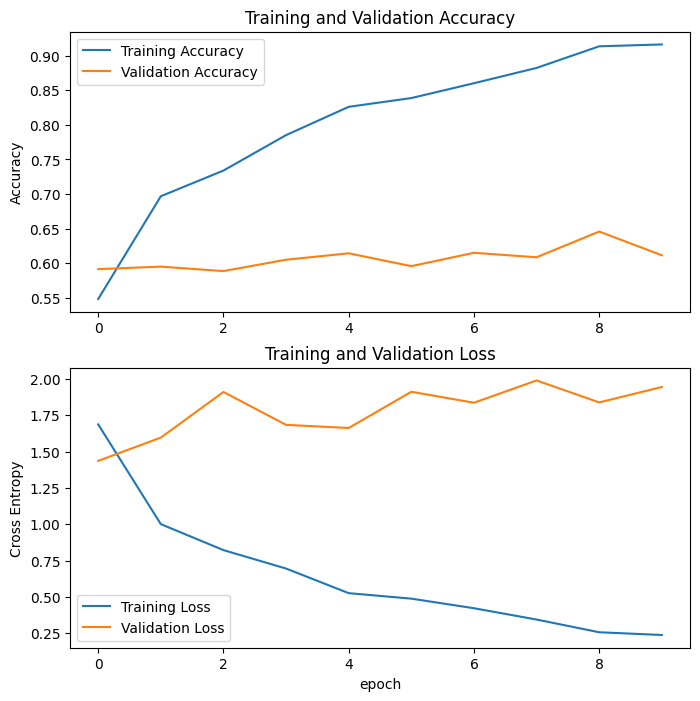

In [ ]:
(
    train_accuracy,
    validation_accuracy,
    train_loss,
    validation_loss,
) = extract_values_from_history(history)
accuracy_and_loss_graph(
    train_accuracy, validation_accuracy, train_loss, validation_loss
)

In [ ]:
mean_metrics(history)

Mean Accuracy: 80.01 +/- 10.85 & Mean Validation Accuracy: 60.71 +/- 1.58
Mean Loss: 0.648 +/- 0.418 & Mean Validation Loss: 1.782 +/- 0.169


### Hyperparameters Tuning

In [ ]:
def model_builder(hp):

    base_model = Xception(
        weights="imagenet",
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNEL),
    )

    base_model.trainable = False

    #####################################################

    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNEL))
    base = base_model(inputs, training=False)

    vectors = keras.layers.GlobalAveragePooling2D()(base)

    size_inner = hp.Choice("size_inner", values=[10, 50, 100])
    inner = keras.layers.Dense(size_inner, activation="relu")(vectors)

    droprate = hp.Choice("dropout", values=[0.2, 0.5, 0.8])
    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax")(drop)
    model = keras.Model(inputs, outputs)

    #####################################################

    hp_learning_rate = hp.Choice("learning_rate", values=[0.0001, 0.001, 0.01, 0.1])
    optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.sparse_categorical_crossentropy,
        metrics=["accuracy"],
    )

    return model

In [ ]:
tuner = kt.Hyperband(
    model_builder,
    objective="accuracy",
    max_epochs=10,
    factor=3,
    directory="kt_for_cats_classification",
    project_name="xception",
)

In [ ]:
best_hps = return_best_hps(tuner, train_set, stop_early)
print_hyperparameter(best_hps)

Trial 30 Complete [00h 04m 24s]
accuracy: 0.35374999046325684

Best accuracy So Far: 0.7239285707473755
Total elapsed time: 00h 52m 56s

      The hyperparameter search is complete.

      - Optimal learning rate: 0.001,

      - Optimal number of layers: 100,

      - Optimal dropout: 0.5.
      


In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 30 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_set, epochs=30, validation_data=val_set)

val_acc_per_epoch = history.history["val_accuracy"]
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print("Best epoch: %d" % (best_epoch,))

Epoch 1/30
175/175 [==============================] - 36s 186ms/step - loss: 1.9283 - accuracy: 0.3966 - val_loss: 1.4162 - val_accuracy: 0.5543
Epoch 2/30
175/175 [==============================] - 32s 183ms/step - loss: 1.4304 - accuracy: 0.5398 - val_loss: 1.2756 - val_accuracy: 0.6029
Epoch 3/30
175/175 [==============================] - 32s 184ms/step - loss: 1.2471 - accuracy: 0.5955 - val_loss: 1.1788 - val_accuracy: 0.6250
Epoch 4/30
175/175 [==============================] - 32s 183ms/step - loss: 1.1532 - accuracy: 0.6214 - val_loss: 1.1191 - val_accuracy: 0.6421
Epoch 5/30
175/175 [==============================] - 33s 187ms/step - loss: 1.0789 - accuracy: 0.6441 - val_loss: 1.1095 - val_accuracy: 0.6271
Epoch 6/30
175/175 [==============================] - 33s 187ms/step - loss: 1.0005 - accuracy: 0.6754 - val_loss: 1.0954 - val_accuracy: 0.6521
Epoch 7/30
175/175 [==============================] - 32s 182ms/step - loss: 0.9647 - accuracy: 0.6768 - val_loss: 1.0902 - val_ac

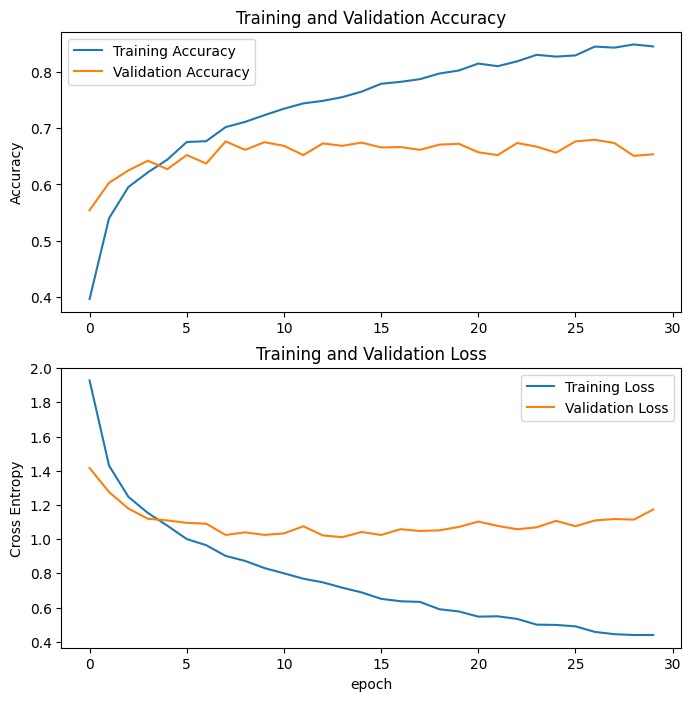

In [ ]:
(
    train_accuracy,
    validation_accuracy,
    train_loss,
    validation_loss,
) = extract_values_from_history(history)
accuracy_and_loss_graph(
    train_accuracy, validation_accuracy, train_loss, validation_loss
)

In [ ]:
mean_metrics(history)

Mean Accuracy: 74.3 +/- 10.18 & Mean Validation Accuracy: 65.55 +/- 2.57
Mean Loss: 0.77 +/- 0.332 & Mean Validation Loss: 1.094 +/- 0.081


In [ ]:
del history
del model
del train_set
del val_set
del tuner
del best_hps
del preprocess_input
gc.collect()

39584

## ResNet50

### Training model

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [ ]:
img_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input, validation_split=0.2
)

train_set = img_gen.flow_from_directory(
    path,
    subset="training",
    seed=42,
    class_mode="sparse",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
)

val_set = img_gen.flow_from_directory(
    path,
    subset="validation",
    seed=42,
    class_mode="sparse",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
)

Found 5600 images belonging to 20 classes.
Found 1400 images belonging to 20 classes.


In [ ]:
base_model = ResNet50(
    weights="imagenet", include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNEL)
)

base_model.trainable = False

inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNEL))

base = base_model(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax")(vectors)

model = keras.Model(inputs, outputs)

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=["accuracy"],
)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 20)                40980     
                                                                 
Total params: 23628692 (90.14 MB)
Trainable params: 40980 (160.08 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
history = model.fit(train_set, epochs=10, validation_data=val_set)

Epoch 1/10
175/175 [==============================] - 43s 206ms/step - loss: 2.6141 - accuracy: 0.5466 - val_loss: 2.4989 - val_accuracy: 0.5614
Epoch 2/10
175/175 [==============================] - 33s 189ms/step - loss: 1.3677 - accuracy: 0.7193 - val_loss: 2.5669 - val_accuracy: 0.6371
Epoch 3/10
175/175 [==============================] - 33s 188ms/step - loss: 0.9656 - accuracy: 0.7984 - val_loss: 2.5025 - val_accuracy: 0.6371
Epoch 4/10
175/175 [==============================] - 34s 193ms/step - loss: 0.8457 - accuracy: 0.8204 - val_loss: 3.4260 - val_accuracy: 0.5793
Epoch 5/10
175/175 [==============================] - 33s 191ms/step - loss: 0.6495 - accuracy: 0.8559 - val_loss: 2.6247 - val_accuracy: 0.6686
Epoch 6/10
175/175 [==============================] - 33s 189ms/step - loss: 0.4525 - accuracy: 0.8904 - val_loss: 2.8740 - val_accuracy: 0.6550
Epoch 7/10
175/175 [==============================] - 34s 193ms/step - loss: 0.4826 - accuracy: 0.8821 - val_loss: 2.7076 - val_ac

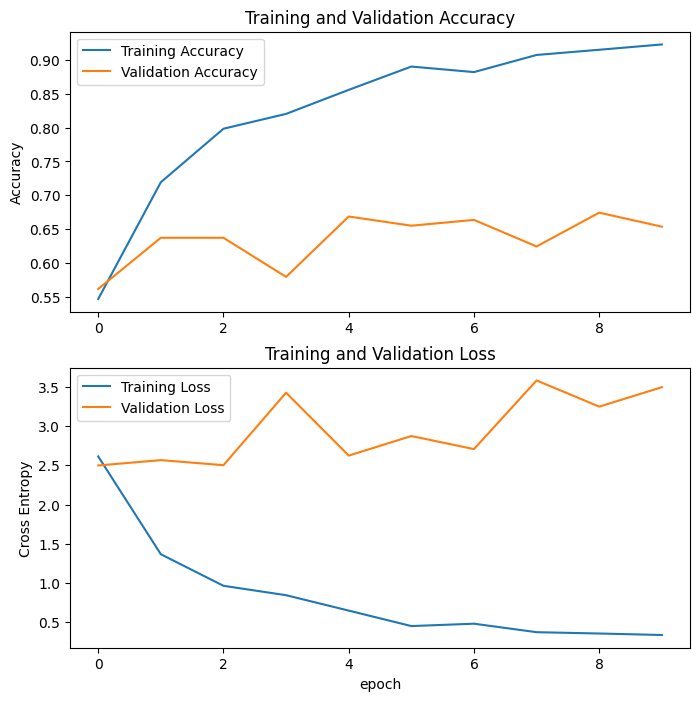

In [ ]:
(
    train_accuracy,
    validation_accuracy,
    train_loss,
    validation_loss,
) = extract_values_from_history(history)
accuracy_and_loss_graph(
    train_accuracy, validation_accuracy, train_loss, validation_loss
)

In [ ]:
mean_metrics(history)

Mean Accuracy: 82.59 +/- 11.07 & Mean Validation Accuracy: 63.54 +/- 3.59
Mean Loss: 0.845 +/- 0.668 & Mean Validation Loss: 2.953 +/- 0.416


### Hyperparameters Tuning

In [ ]:
def model_builder(hp):

    base_model = ResNet50(
        weights="imagenet",
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNEL),
    )

    base_model.trainable = False

    #####################################################

    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNEL))
    base = base_model(inputs, training=False)

    vectors = keras.layers.GlobalAveragePooling2D()(base)

    size_inner = hp.Choice("size_inner", values=[10, 50, 100])
    inner = keras.layers.Dense(size_inner, activation="relu")(vectors)

    droprate = hp.Choice("dropout", values=[0.2, 0.5, 0.8])
    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(20, activation="softmax")(drop)
    model = keras.Model(inputs, outputs)

    #####################################################

    hp_learning_rate = hp.Choice("learning_rate", values=[0.0001, 0.001, 0.01, 0.1])
    optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.sparse_categorical_crossentropy,
        metrics=["accuracy"],
    )

    return model

In [ ]:
tuner = kt.Hyperband(
    model_builder,
    objective="accuracy",
    max_epochs=10,
    factor=3,
    directory="kt_for_cats_classification",
    project_name="resNet50",
)

In [ ]:
best_hps = return_best_hps(tuner, train_set, stop_early)
print_hyperparameter(best_hps)

Trial 30 Complete [00h 04m 47s]
accuracy: 0.18321429193019867

Best accuracy So Far: 0.7826785445213318
Total elapsed time: 00h 58m 57s

      The hyperparameter search is complete.

      - Optimal learning rate: 0.0001,

      - Optimal number of layers: 100,

      - Optimal dropout: 0.2.
      


In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 30 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_set, epochs=30, validation_data=val_set)

val_acc_per_epoch = history.history["val_accuracy"]
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print("Best epoch: %d" % (best_epoch,))

Epoch 1/30
175/175 [==============================] - 38s 199ms/step - loss: 2.4988 - accuracy: 0.2648 - val_loss: 1.8549 - val_accuracy: 0.5000
Epoch 2/30
175/175 [==============================] - 33s 190ms/step - loss: 1.6377 - accuracy: 0.5102 - val_loss: 1.4240 - val_accuracy: 0.5829
Epoch 3/30
175/175 [==============================] - 33s 189ms/step - loss: 1.3055 - accuracy: 0.6062 - val_loss: 1.2305 - val_accuracy: 0.6443
Epoch 4/30
175/175 [==============================] - 33s 189ms/step - loss: 1.1043 - accuracy: 0.6566 - val_loss: 1.1327 - val_accuracy: 0.6564
Epoch 5/30
175/175 [==============================] - 33s 190ms/step - loss: 0.9965 - accuracy: 0.6825 - val_loss: 1.0823 - val_accuracy: 0.6750
Epoch 6/30
175/175 [==============================] - 34s 193ms/step - loss: 0.9076 - accuracy: 0.7211 - val_loss: 1.0284 - val_accuracy: 0.6850
Epoch 7/30
175/175 [==============================] - 33s 191ms/step - loss: 0.8150 - accuracy: 0.7437 - val_loss: 0.9911 - val_ac

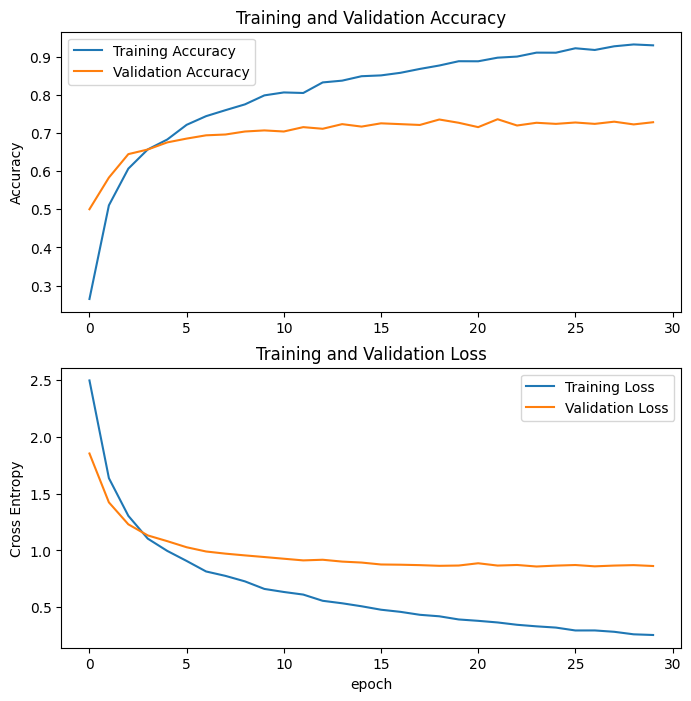

In [ ]:
(
    train_accuracy,
    validation_accuracy,
    train_loss,
    validation_loss,
) = extract_values_from_history(history)
accuracy_and_loss_graph(
    train_accuracy, validation_accuracy, train_loss, validation_loss
)

In [ ]:
mean_metrics(history)

Mean Accuracy: 80.39 +/- 14.28 & Mean Validation Accuracy: 69.97 +/- 4.86
Mean Loss: 0.653 +/- 0.472 & Mean Validation Loss: 0.974 +/- 0.206


In [ ]:
del history
del model
del train_set
del val_set
del tuner
del best_hps
del preprocess_input
gc.collect()

47384

## EfficientNet

### Training model

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input

In [ ]:
img_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input, validation_split=0.2
)

train_set = img_gen.flow_from_directory(
    path,
    subset="training",
    seed=42,
    class_mode="sparse",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
)

val_set = img_gen.flow_from_directory(
    path,
    subset="validation",
    seed=42,
    class_mode="sparse",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
)

Found 5600 images belonging to 20 classes.
Found 1400 images belonging to 20 classes.


In [ ]:
base_model = EfficientNetB7(
    weights="imagenet", include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNEL)
)

base_model.trainable = False

inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNEL))

base = base_model(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax")(vectors)

model = keras.Model(inputs, outputs)

258076736/258076736 [==============================] - 9s 0us/step


In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=["accuracy"],
)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb7 (Functional  (None, 7, 7, 2560)        64097687  
 )                                                               
                                                                 
 global_average_pooling2d_2  (None, 2560)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 20)                51220     
                                                                 
Total params: 64148907 (244.71 MB)
Trainable params: 51220 (200.08 KB)
Non-trainable params: 64097687 (244.51 MB)
_________________________________________________________________


In [ ]:
history = model.fit(train_set, epochs=10, validation_data=val_set)

Epoch 1/10
175/175 [==============================] - 108s 482ms/step - loss: 1.2356 - accuracy: 0.6300 - val_loss: 1.1553 - val_accuracy: 0.6607
Epoch 2/10
175/175 [==============================] - 78s 443ms/step - loss: 0.6595 - accuracy: 0.7834 - val_loss: 1.2409 - val_accuracy: 0.6571
Epoch 3/10
175/175 [==============================] - 78s 447ms/step - loss: 0.4706 - accuracy: 0.8388 - val_loss: 1.2715 - val_accuracy: 0.6821
Epoch 4/10
175/175 [==============================] - 78s 448ms/step - loss: 0.3950 - accuracy: 0.8693 - val_loss: 1.2272 - val_accuracy: 0.6971
Epoch 5/10
175/175 [==============================] - 79s 449ms/step - loss: 0.2865 - accuracy: 0.9014 - val_loss: 1.3885 - val_accuracy: 0.6679
Epoch 6/10
175/175 [==============================] - 79s 449ms/step - loss: 0.2284 - accuracy: 0.9232 - val_loss: 1.4119 - val_accuracy: 0.6836
Epoch 7/10
175/175 [==============================] - 79s 449ms/step - loss: 0.2062 - accuracy: 0.9291 - val_loss: 1.4963 - val_a

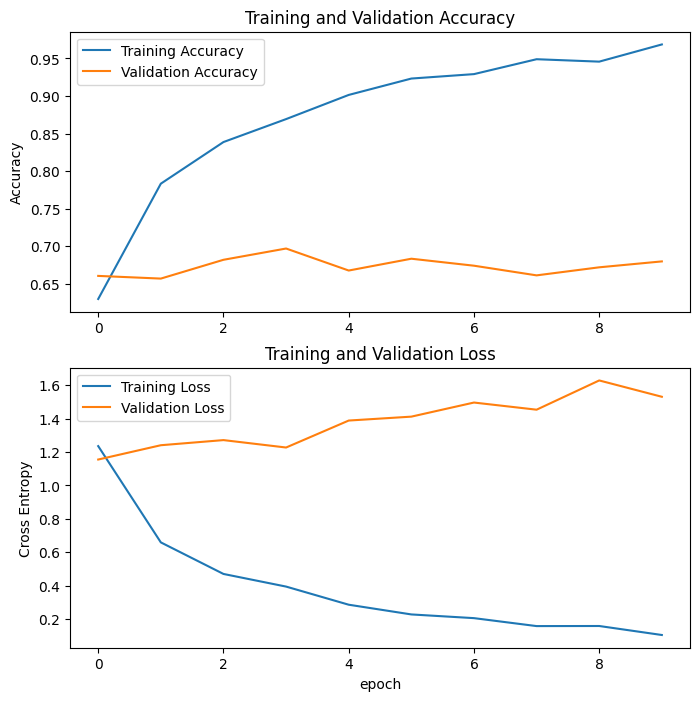

In [ ]:
(
    train_accuracy,
    validation_accuracy,
    train_loss,
    validation_loss,
) = extract_values_from_history(history)
accuracy_and_loss_graph(
    train_accuracy, validation_accuracy, train_loss, validation_loss
)

In [ ]:
mean_metrics(history)

Mean Accuracy: 87.38 +/- 9.74 & Mean Validation Accuracy: 67.36 +/- 1.18
Mean Loss: 0.391 +/- 0.324 & Mean Validation Loss: 1.38 +/- 0.145


### Hyperparameters Tuning

In [ ]:
def model_builder(hp):

    base_model = EfficientNetB7(
        weights="imagenet",
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNEL),
    )

    base_model.trainable = False

    #####################################################

    inputs = keras.Input(shape=((IMG_HEIGHT, IMG_WIDTH, CHANNEL)))
    base = base_model(inputs, training=False)

    vectors = keras.layers.GlobalAveragePooling2D()(base)

    size_inner = hp.Choice("size_inner", values=[10, 50, 100])
    inner = keras.layers.Dense(size_inner, activation="relu")(vectors)

    droprate = hp.Choice("dropout", values=[0.2, 0.5, 0.8])
    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(20, activation="softmax")(drop)
    model = keras.Model(inputs, outputs)

    #####################################################

    hp_learning_rate = hp.Choice("learning_rate", values=[0.0001, 0.001, 0.01, 0.1])
    optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.sparse_categorical_crossentropy,
        metrics=["accuracy"],
    )

    return model

In [ ]:
tuner = kt.Hyperband(
    model_builder,
    objective="accuracy",
    max_epochs=10,
    factor=3,
    directory="kt_for_cats_classification",
    project_name="efficientBNet7",
)

In [ ]:
best_hps = return_best_hps(tuner, train_set, stop_early)
print_hyperparameter(best_hps)

Trial 30 Complete [00h 11m 08s]
accuracy: 0.15410713851451874

Best accuracy So Far: 0.8139285445213318
Total elapsed time: 02h 25m 45s

      The hyperparameter search is complete.

      - Optimal learning rate: 0.01,

      - Optimal number of layers: 100,

      - Optimal dropout: 0.2.
      


In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 30 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    train_set,
    epochs=30,
    validation_data=val_set
    )

val_acc_per_epoch = history.history["val_accuracy"]
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print("Best epoch: %d" % (best_epoch,))!

Epoch 1/30
175/175 [==============================] - 103s 474ms/step - loss: 1.4509 - accuracy: 0.5462 - val_loss: 1.2432 - val_accuracy: 0.6036
Epoch 2/30
175/175 [==============================] - 79s 449ms/step - loss: 1.0151 - accuracy: 0.6684 - val_loss: 1.1291 - val_accuracy: 0.6264
Epoch 3/30
175/175 [==============================] - 78s 448ms/step - loss: 0.9051 - accuracy: 0.7013 - val_loss: 1.1368 - val_accuracy: 0.6486
Epoch 4/30
175/175 [==============================] - 79s 449ms/step - loss: 0.7973 - accuracy: 0.7305 - val_loss: 1.2407 - val_accuracy: 0.6500
Epoch 5/30
175/175 [==============================] - 78s 448ms/step - loss: 0.7103 - accuracy: 0.7664 - val_loss: 1.1844 - val_accuracy: 0.6650
Epoch 6/30
175/175 [==============================] - 78s 448ms/step - loss: 0.6456 - accuracy: 0.7818 - val_loss: 1.3094 - val_accuracy: 0.6593
Epoch 7/30
175/175 [==============================] - 79s 449ms/step - loss: 0.6461 - accuracy: 0.7880 - val_loss: 1.3786 - val_a

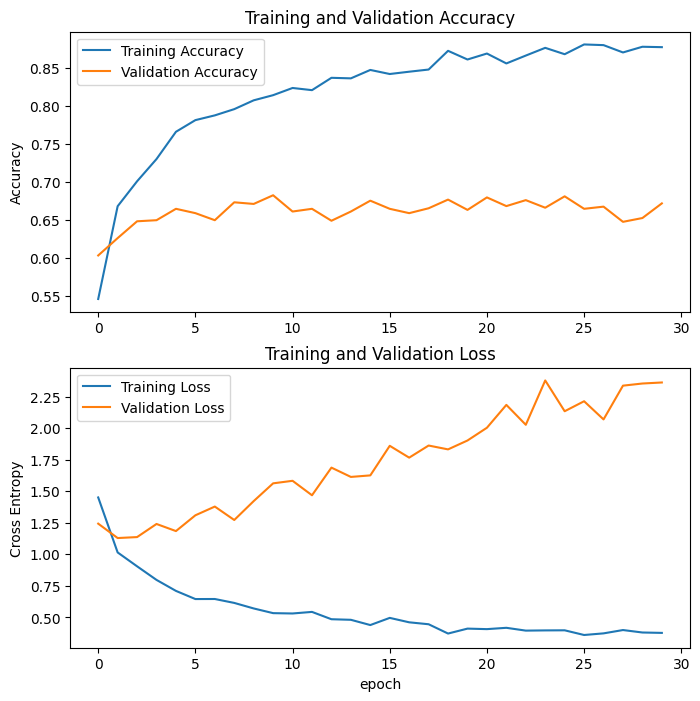

In [ ]:
(
    train_accuracy,
    validation_accuracy,
    train_loss,
    validation_loss,
) = extract_values_from_history(history)
accuracy_and_loss_graph(
    train_accuracy, validation_accuracy, train_loss, validation_loss
)

In [ ]:
mean_metrics(history)

Mean Accuracy: 81.89 +/- 7.36 & Mean Validation Accuracy: 66.18 +/- 1.62
Mean Loss: 0.549 +/- 0.232 & Mean Validation Loss: 1.738 +/- 0.399


In [ ]:
del history
del model
del train_set
del val_set
del tuner
del best_hps
del preprocess_input
gc.collect()

78352

## Summary

The results for accuracy and loss on validation set are presented in the table below. These results are obtained after tuning.

|Model | Accuracy | Loss |
|------|--------------|----------|
|Xception | 65.93% | 1.16|
|ResNet50 | 69.97% | 0.974 |
| EfficientNetB7 | 66.18% | 1.738 |

# Training the best model

In [14]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50

## Data Augmentation

In [15]:
img_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=50,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode="nearest",
)

train_set = img_gen.flow_from_directory(
    path,
    class_mode="sparse",
    subset="training",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
)

val_set = img_gen.flow_from_directory(
    path,
    class_mode="sparse",
    subset="validation",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 5600 images belonging to 20 classes.
Found 1400 images belonging to 20 classes.


## Prepare checkpointing

In [16]:
checkpoint = keras.callbacks.ModelCheckpoint(
    "models/resnet50_{epoch:02d}_{val_accuracy:.3f}.h5",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max",
)

## Training the model

In [17]:
model = make_model(model=ResNet50, learning_rate=0.001, size_inner=50, droprate=0.2)
history = model.fit(
    train_set, epochs=30, validation_data=val_set, callbacks=[checkpoint]
)

94765736/94765736 [==============================] - 5s 0us/step
Epoch 1/30
175/175 [==============================] - 100s 521ms/step - loss: 2.3580 - accuracy: 0.2921 - val_loss: 1.7319 - val_accuracy: 0.4850
Epoch 2/30
175/175 [==============================] - 89s 506ms/step - loss: 1.6925 - accuracy: 0.4584 - val_loss: 1.4294 - val_accuracy: 0.5686
Epoch 3/30
175/175 [==============================] - 88s 504ms/step - loss: 1.4144 - accuracy: 0.5357 - val_loss: 1.3324 - val_accuracy: 0.5714
Epoch 4/30
175/175 [==============================] - 89s 506ms/step - loss: 1.3143 - accuracy: 0.5713 - val_loss: 1.2166 - val_accuracy: 0.6207
Epoch 5/30
175/175 [==============================] - 89s 510ms/step - loss: 1.2314 - accuracy: 0.5796 - val_loss: 1.2024 - val_accuracy: 0.6136
Epoch 6/30
175/175 [==============================] - 89s 511ms/step - loss: 1.1947 - accuracy: 0.5991 - val_loss: 1.1361 - val_accuracy: 0.6421
Epoch 7/30
175/175 [==============================] - 90s 513ms/

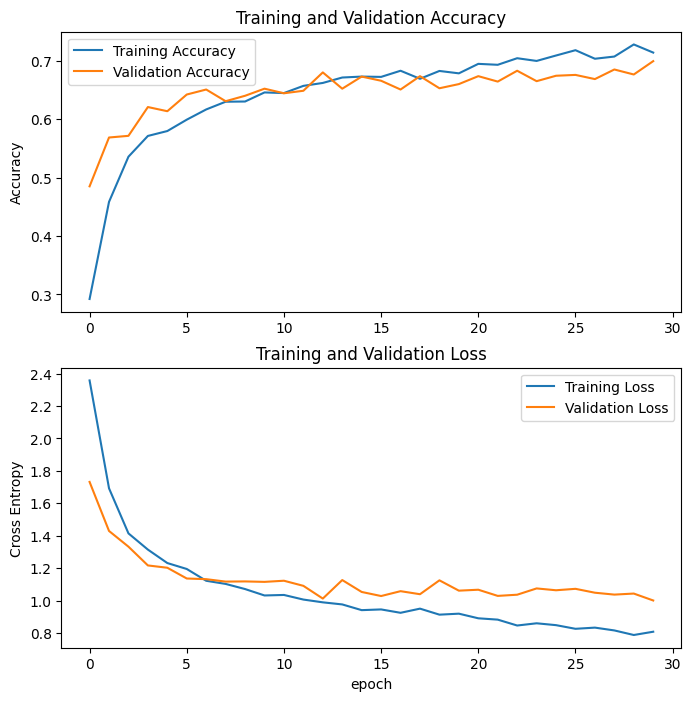

In [18]:
(
    train_accuracy,
    validation_accuracy,
    train_loss,
    validation_loss,
) = extract_values_from_history(history)
accuracy_and_loss_graph(
    train_accuracy, validation_accuracy, train_loss, validation_loss
)

In [19]:
mean_metrics(history)

Mean Accuracy: 64.41 +/- 8.78 & Mean Validation Accuracy: 64.8 +/- 4.2
Mean Loss: 1.051 +/- 0.313 & Mean Validation Loss: 1.124 +/- 0.145
